In [1]:
from __future__ import absolute_import
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras as keras
import numpy as np
import random
from keras.datasets import mnist
from keras.models import Model,Sequential
from keras.layers import Input, Flatten, Dense, Dropout, Lambda,Embedding, Reshape, Activation
from keras.layers import Conv2D, Activation,AveragePooling2D,AveragePooling1D,Conv1D, GlobalMaxPooling1D, MaxPooling1D,GlobalAveragePooling1D
from keras import backend as K
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold 
from scipy.spatial.distance import euclidean

In [2]:
#Siamese Network Implementation 
num_classes = 12
epochs = 20
 
def euclid_dis(vects):
  x,y = vects
  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))
 
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
 
def contrastive_loss(y_true, y_pred):
    y_true=tf.cast(y_true, tf.float32)
    y_pred=tf.cast(y_pred, tf.float32)
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def create_pairs_new3(x, digit_indices):
    pairs = []
    labels = []
    
    for d in range(num_classes):
        #n'i içeri aldım böylese her class için max loop yapabiliyoruz.
        n=min([len(digit_indices[d])]) -1
        for i in range(n):
            #Random bir Equal index buluyoruz while kullanarak, kendisi(i) haric
            #randomIndiceTrue = random.randrange(0, min([len(digit_indices[d])]))
            randomIndiceTrue=-1
            while True:
                if randomIndiceTrue != i:
                    break
                else:
                    randomIndiceTrue = random.randrange(0, min([len(digit_indices[d])]))
            
            z1, z2 = digit_indices[d][i], digit_indices[d][randomIndiceTrue]
            pairs += [[x[z1], x[z2]]]
            
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            
            #Random bir Non Equal index buluyoruz.
            randomIndiceFalse = random.randrange(0, min([len(digit_indices[dn])]))
            
            z1, z2 = digit_indices[d][i], digit_indices[dn][randomIndiceFalse]
            pairs += [[x[z1], x[z2]]]
            labels += [1,0]
    return np.array(pairs), np.array(labels)



def create_base_net_new2(input_shape):
    height=376
    depth=1
    num_classes=12
    input = Input(shape = input_shape)
    #x = Sequential()(input)
    x = Reshape((height, depth))(input)
    x = Conv1D(12, 3, strides=1, padding='valid', activation='relu')(x)
    x = AveragePooling1D(3)(x)
    x = Conv1D(8, 3, strides=1, padding='valid', activation='relu')(x)
    x = AveragePooling1D(3)(x)
    x = Conv1D(6, 3, strides=1, padding='valid', activation='relu')(x)
    #x = AveragePooling1D(3)(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation = 'relu')(x)
    model = Model(input, x)
    model.summary()
    #print(model.summary())
    return model


def get_f1(y_true, y_pred): 
    pred = K.cast(y_pred < 0.5, y_true.dtype)
    true_positives = K.sum(K.round(K.clip(y_true * pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall)
    return f1_val

def compute_f1(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    pred=pred*1
    TN,FP,FN,TP=confusion_matrix(y_true, pred).ravel()

    recall = TP/(TP+FN)
    precision=TP/(TP+FP)

    f1_val = 2*(precision*recall)/(precision+recall)
    return f1_val




In [3]:
def compute_cosine_f1(t_pairs, t_y):
    # Set the cosine similarity threshold
    cosine_threshold = 0.6
    
    # Initialize variables for true positives, false positives, false negatives, and true negatives
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    # Iterate through the pairs and compute cosine similarity
    for i in range(np.shape(t_y)[0]):
        cos_result = cosine_similarity(t_pairs[i, 0].reshape(1, -1), t_pairs[i, 1].reshape(1, -1))
        
        # Check conditions for true positive, false positive, false negative, and true negative
        if t_y[i] == 1 and cos_result >= cosine_threshold:
            cTP = cTP + 1
        elif t_y[i] != 1 and cos_result >= cosine_threshold:
            cFP = cFP + 1
        elif t_y[i] == 1 and cos_result < cosine_threshold:
            cFN = cFN + 1
        elif t_y[i] != 1 and cos_result < cosine_threshold:
            cTN = cTN + 1
        
    # Calculate recall
    recall = cTP / (cTP + cFN)
    
    # Calculate precision
    precision = cTP / (cTP + cFP)
    
    # Calculate the F1 score
    f1_cosine_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_cosine_val


In [4]:
def manhattan_distance(point1, point2):
    return np.sum(np.abs(point1 - point2))

def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def compute_manhattan_f1(t_pairs, t_y):
    manhattan_threshold = 0.9

    # Initialize variables for true positives, false positives, false negatives, and true negatives
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    # Max-Min Normalizasyonu
    t_pairs_normalized = np.array([min_max_normalize(pair) for pair in t_pairs])

    # Iterate through the pairs and compute Manhattan distance
    for i in range(np.shape(t_y)[0]):
        result = manhattan_distance(t_pairs_normalized[i, 0], t_pairs_normalized[i, 1])

        # Check conditions for true positive, false positive, false negative, and true negative
        if t_y[i] == 1 and result >= manhattan_threshold:
            cTP += 1
        elif t_y[i] != 1 and result >= manhattan_threshold:
            cFP += 1
        elif t_y[i] == 1 and result < manhattan_threshold:
            cFN += 1
        elif t_y[i] != 1 and result < manhattan_threshold:
            cTN += 1

    # Calculate recall  
    recall = cTP / (cTP + cFN)

    # Calculate precision
    precision = cTP / (cTP + cFP)

    # Calculate the F1 score for Manhattan distance
    f1_manhattan_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_manhattan_val


In [5]:
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def compute_euclidean_f1(t_pairs, t_y):
    # Set the Euclidean distance threshold
    euclidean_threshold = 0.7
    
    # Initialize variables for true positives, false positives, false negatives, and true negatives
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    # Max-Min Normalization
    t_pairs_normalized = np.array([min_max_normalize(pair) for pair in t_pairs])
    
    # Iterate through the pairs and compute Euclidean distance
    for i in range(np.shape(t_y)[0]):
        result = euclidean_distance(t_pairs_normalized[i, 0], t_pairs_normalized[i, 1])
        
        # Check conditions for true positive, false positive, false negative, and true negative
        if t_y[i] == 1 and result >= euclidean_threshold:
            cTP += 1
        elif t_y[i] != 1 and result >= euclidean_threshold:
            cFP += 1
        elif t_y[i] == 1 and result < euclidean_threshold:
            cFN += 1
        elif t_y[i] != 1 and result < euclidean_threshold:
            cTN += 1
        
    # Calculate recall
    recall = cTP / (cTP + cFN)
    
    # Calculate precision
    precision = cTP / (cTP + cFP)
    
    # Calculate the F1 score for Euclidean distance
    f1_euclidean_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_euclidean_val


In [6]:
from scipy.stats import pearsonr

def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def compute_pearsonr_f1(t_pairs, t_y):
    # Set the Pearson correlation coefficient threshold
    pearsonr_threshold = 0.65
    
    # Initialize variables for true positives, false positives, false negatives, and true negatives
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    for i in range(np.shape(t_y)[0]):
        # Apply min-max normalization to each pair
        t_pair_normalized = np.array([min_max_normalize(pair) for pair in t_pairs[i]])
        
        # Flatten the 2-D arrays to 1-D arrays
        t_pair_normalized_1d = t_pair_normalized[0].flatten()
        t_pair_normalized_2d = t_pair_normalized[1].flatten()
        
        # Calculate the Pearson correlation coefficient
        result, _ = pearsonr(t_pair_normalized_1d, t_pair_normalized_2d)
        
        # Check conditions for true positive, false positive, false negative, and true negative
        if t_y[i] == 1 and abs(result) >= pearsonr_threshold:
            cTP += 1
        elif t_y[i] != 1 and abs(result) >= pearsonr_threshold:
            cFP += 1
        elif t_y[i] == 1 and abs(result) < pearsonr_threshold:
            cFN += 1
        elif t_y[i] != 1 and abs(result) < pearsonr_threshold:
            cTN += 1
        
    # Calculate recall
    recall = cTP / (cTP + cFN)
    
    # Calculate precision
    precision = cTP / (cTP + cFP)
    
    # Calculate the F1 score for Pearson correlation coefficient
    f1_pearsonR_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_pearsonR_val


In [7]:
def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def chebyshev_distance(point1, point2):
    return np.max(np.abs(point1 - point2))

def compute_chebyshev_f1(t_pairs, t_y):
    # Set the Chebyshev distance threshold
    chebyshev_threshold = 0.6
    
    # Initialize variables for true positives, false positives, false negatives, and true negatives
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    for i in range(np.shape(t_y)[0]):
        # Apply min-max normalization to each pair
        t_pair_normalized = np.array([min_max_normalize(pair) for pair in t_pairs[i]])
        
        # Calculate the Chebyshev distance
        result = chebyshev_distance(t_pair_normalized[0], t_pair_normalized[1])
        
        # Check conditions for true positive, false positive, false negative, and true negative
        if t_y[i] == 1 and result >= chebyshev_threshold:
            cTP += 1
        elif t_y[i] != 1 and result >= chebyshev_threshold:
            cFP += 1
        elif t_y[i] == 1 and result < chebyshev_threshold:
            cFN += 1
        elif t_y[i] != 1 and result < chebyshev_threshold:
            cTN += 1
        
    # Calculate recall
    recall = cTP / (cTP + cFN)
    
    # Calculate precision
    precision = cTP / (cTP + cFP)
    
    # Calculate the F1 score for Chebyshev distance
    f1_chebyshev_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_chebyshev_val


In [8]:
from scipy.spatial.distance import braycurtis

def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def compute_bray_curtis_f1(t_pairs, t_y):
    # Set the Bray-Curtis dissimilarity threshold
    bray_curtis_threshold = 0.6
    
    # Initialize variables for true positives, false positives, false negatives, and true negatives
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    for i in range(np.shape(t_y)[0]):
        # Apply min-max normalization to each pair
        t_pair_normalized = np.array([min_max_normalize(pair) for pair in t_pairs[i]])
        
        # Flatten the arrays to 1-D
        t_pair_normalized_1d = t_pair_normalized[0].flatten()
        t_pair_normalized_2d = t_pair_normalized[1].flatten()
        
        # Calculate the Bray-Curtis dissimilarity
        result = braycurtis(t_pair_normalized_1d, t_pair_normalized_2d)
        
        # Check conditions for true positive, false positive, false negative, and true negative
        if t_y[i] == 1 and result <= bray_curtis_threshold:
            cTP += 1
        elif t_y[i] != 1 and result <= bray_curtis_threshold:
            cFP += 1
        elif t_y[i] == 1 and result > bray_curtis_threshold:
            cFN += 1
        elif t_y[i] != 1 and result > bray_curtis_threshold:
            cTN += 1
        
    # Calculate recall
    recall = cTP / (cTP + cFN)
    
    # Calculate precision
    precision = cTP / (cTP + cFP)
    
    # Calculate the F1 score for Bray-Curtis dissimilarity
    f1_bray_curtis_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_bray_curtis_val


In [9]:
def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def calculate_jaccard_similarity(set1, set2):
    intersection = np.sum(set1 & set2)
    union = np.sum(set1 | set2)
    if union == 0:
        return 0.0
    return intersection / union

def compute_jaccard_f1(t_pairs, t_y):
    jaccard_threshold = 0.4
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    for i in range(np.shape(t_y)[0]):
        # Apply min-max normalization to each pair
        t_pair_normalized = np.array([min_max_normalize(pair) for pair in t_pairs[i]])
        
        # Flatten the arrays to 1-D and convert to binary (0 or 1)
        t_pair_normalized_1d = (t_pair_normalized[0] >= 0.5).astype(int)
        t_pair_normalized_2d = (t_pair_normalized[1] >= 0.5).astype(int)
        
        # Calculate the Jaccard similarity
        result = calculate_jaccard_similarity(t_pair_normalized_1d, t_pair_normalized_2d)
        
        if t_y[i] == 1 and result >= jaccard_threshold:
            cTP += 1
        elif t_y[i] != 1 and result >= jaccard_threshold:
            cFP += 1
        elif t_y[i] == 1 and result < jaccard_threshold:
            cFN += 1
        elif t_y[i] != 1 and result < jaccard_threshold:
            cTN += 1
        
    recall = cTP / (cTP + cFN)
    precision = cTP / (cTP + cFP)
    f1_jaccard_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_jaccard_val


In [10]:
from scipy.spatial.distance import canberra

def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def compute_canberra_f1(t_pairs, t_y):
    canberra_threshold = 0.7
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    for i in range(np.shape(t_y)[0]):
        # Apply Max-Min normalization to each pair
        t_pair_normalized = np.array([min_max_normalize(pair) for pair in t_pairs[i]])
        
        # Calculate Canberra distance after normalization
        result = canberra(t_pair_normalized[0].flatten(), t_pair_normalized[1].flatten())  # Flatten to 1-D arrays
        
        if t_y[i] == 1 and result >= canberra_threshold:
            cTP += 1
        elif t_y[i] != 1 and result >= canberra_threshold:
            cFP += 1
        elif t_y[i] == 1 and result < canberra_threshold:
            cFN += 1
        elif t_y[i] != 1 and result < canberra_threshold:
            cTN += 1
        
    recall = cTP / (cTP + cFN)
    precision = cTP / (cTP + cFP)
    f1_canberra_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_canberra_val


In [11]:
import numpy as np

def minkowski_distance(point1, point2, p):
    return np.sum(np.abs(point1 - point2) ** p) ** (1/p)



def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def compute_minkowski_f1(t_pairs, t_y, p):
    minkowski_threshold = 0.7
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    # Max-Min Normalization
    t_pairs_normalized = np.array([min_max_normalize(pair) for pair in t_pairs])
    
    for i in range(np.shape(t_y)[0]):
        result = minkowski_distance(t_pairs_normalized[i, 0], t_pairs_normalized[i, 1], p)
        if t_y[i] == 1 and result >= minkowski_threshold:
            cTP += 1
        elif t_y[i] != 1 and result >= minkowski_threshold:
            cFP += 1
        elif t_y[i] == 1 and result < minkowski_threshold:
            cFN += 1
        elif t_y[i] != 1 and result < minkowski_threshold:
            cTN += 1
        
    recall = cTP / (cTP + cFN)
    precision = cTP / (cTP + cFP)
    f1_minkowski_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_minkowski_val




In [12]:
import numpy as np

def hamming_distance(vector1, vector2):
    return np.sum(vector1 != vector2)

def compute_hamming_f1(t_pairs, t_y):
    hamming_threshold = 0.9
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0

    for i in range(np.shape(t_y)[0]):
        t_pair = t_pairs[i]  # Get the pair of vectors

        # Calculate Hamming distance using the previously defined hamming_distance function
        result = hamming_distance(t_pair[0], t_pair[1])

        if t_y[i] == 1 and result <= hamming_threshold:
            cTP += 1
        elif t_y[i] != 1 and result <= hamming_threshold:
            cFP += 1
        elif t_y[i] == 1 and result > hamming_threshold:
            cFN += 1
        elif t_y[i] != 1 and result > hamming_threshold:
            cTN += 1

    recall = cTP / (cTP + cFN)
    precision = cTP / (cTP + cFP)
    f1_hamming_val = 2 * (precision * recall) / (precision + recall)

    return f1_hamming_val


In [13]:
def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def compute_hamming_f1(t_pairs, t_y):
    hamming_threshold = 0.9
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    for i in range(np.shape(t_y)[0]):
        # Apply min-max normalization to each pair
        t_pair_normalized = np.array([min_max_normalize(pair) for pair in t_pairs[i]])
        
        # Flatten the arrays to 1-D and convert to binary (0 or 1)
        t_pair_normalized_1d = (t_pair_normalized[0] >= 0.5).astype(int)
        t_pair_normalized_2d = (t_pair_normalized[1] >= 0.5).astype(int)
        
        # Calculate Hamming distance
        result = np.sum(t_pair_normalized_1d != t_pair_normalized_2d) / len(t_pair_normalized_1d)
        
        if t_y[i] == 1 and result <= hamming_threshold:
            cTP += 1
        elif t_y[i] != 1 and result <= hamming_threshold:
            cFP += 1
        elif t_y[i] == 1 and result > hamming_threshold:
            cFN += 1
        elif t_y[i] != 1 and result > hamming_threshold:
            cTN += 1
        
    recall = cTP / (cTP + cFN)
    precision = cTP / (cTP + cFP)
    f1_hamming_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_hamming_val


In [14]:
#Dataset
df=pd.read_csv('db_dep_dataset_1_noname.csv',delimiter=';',header=None)
df
# Table names are anonymized.
# First column: TABLE_UniqueTableNumber_ModuleNumber
# Second column: Class number. Equal to Module Number-1. There are 12 classes in totally.
# Third column: Unique table number

,0,1,2,3,4,5,6,7,8,9,...,369,370,371,372,373,374,375,376,377,378
0,TABLE_1_1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TABLE_2_1,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TABLE_3_1,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TABLE_4_1,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TABLE_5_1,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,TABLE_116_12,11,116,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116,TABLE_117_12,11,117,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117,TABLE_118_12,11,118,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
118,TABLE_119_12,11,119,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Separation X and Y values
Y = df[1]

Y=Y.values

#First three columns removed.
X = df
X = X.drop(0,axis=1)
X = X.drop(1,axis=1)
X = X.drop(2,axis=1)

X=X.values

In [16]:
Y = df[1]

Y=Y.values

X = df
X = X.drop(0,axis=1)
X = X.drop(1,axis=1)
X = X.drop(2,axis=1)
X=X.values

cvTestscoresSiameseAll=[]
cvTestscoresCosineAll=[]
cvTestscoresManhattanAll=[]
cvTestscoresEuclideanAll=[]
cvTestscoresBrayCurtisAll=[]
cvTestscoresChebysevAll=[]
cvTestscoresPearsonRAll=[]
cvTestscoresJaccardAll=[]
cvTestscoresHammingAll=[]
cvTestscoresCanberraAll=[]
cvTestscoresMinkowskiAll=[]

for i in range(100):
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    cvTrainscores = []
    cvTestscores = []
    cvi=0
    cvTrainscoresCosine = []
    cvTestscoresCosine = []

    cvTrainscoresManhattan =[]
    cvTestscoresManhattan =[]

    cvTrainscoresEuclidean =[]
    cvTestscoresEuclidean =[]

    cvTrainscoresBrayCurtis =[]
    cvTestscoresBrayCurtis =[]

    cvTrainscoresChebysev =[]
    cvTestscoresChebysev =[]

    cvTrainscoresPearsonR =[]
    cvTestscoresPearsonR =[]

    cvTrainscoresJaccard =[]
    cvTestscoresJaccard =[]

    cvTrainscoresHamming =[]
    cvTestscoresHamming =[]

    cvTrainscoresCanberra =[]
    cvTestscoresCanberra =[]

    cvTrainscoresMinkowski =[]
    cvTestscoresMinkowski =[]
    
    for train, test in kfold.split(X, Y):
        
        cvi=cvi+1
        print("n-fold: "+str(cvi))

        x_train = X[train]
        x_test = X[test]
        y_train = Y[train]
        y_test = Y[test]

        x_train = x_train.reshape(x_train.shape[0], 376, 1)
        x_test = x_test.reshape(x_test.shape[0], 376, 1)
        input_shape = (376, 1)
        print(x_train.shape)
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        y_train = y_train.astype('float32')
        y_test = y_test.astype('float32')
        input_shape = (376,1)

        print(input_shape)

        # create training+test positive and negative pairs
        digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
        tr_pairs, tr_y = create_pairs_new3(x_train, digit_indices)

        digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
        te_pairs, te_y = create_pairs_new3(x_test, digit_indices)

        # network definition
        base_network = create_base_net_new2(input_shape)

        print(input_shape)

        input_a = Input(shape=input_shape)
        input_b = Input(shape=input_shape)

        processed_a = base_network(input_a)
        processed_b = base_network(input_b)

        distance = Lambda(euclid_dis,
                      output_shape=eucl_dist_output_shape)([processed_a, processed_b])

        model = Model([input_a, input_b], distance)

        #train
        model.compile(loss=contrastive_loss, optimizer='adam', metrics=[get_f1])

        model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
              batch_size=16,
              epochs=epochs,
              validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

        # compute final accuracy on training and test sets for n-fold
        p=2
        y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
        tr_acc = compute_f1(tr_y, y_pred)
        tr_f1_cosine = compute_cosine_f1(tr_pairs,tr_y)
        tr_f1_manhattan = compute_manhattan_f1(tr_pairs,tr_y)
        tr_f1_bray_curtis = compute_bray_curtis_f1(tr_pairs,tr_y)
        tr_f1_euclidean = compute_euclidean_f1(tr_pairs,tr_y)
        tr_f1_chebysev = compute_chebyshev_f1(tr_pairs,tr_y)
        tr_f1_pearsonR = compute_pearsonr_f1(tr_pairs,tr_y)
        tr_f1_jaccard = compute_jaccard_f1(tr_pairs,tr_y)
        tr_f1_hamming = compute_hamming_f1(tr_pairs,tr_y)
        tr_f1_canberra = compute_canberra_f1(tr_pairs,tr_y)
        tr_f1_minkowski = compute_minkowski_f1(tr_pairs,tr_y,p)
        

        y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
        te_acc = compute_f1(te_y, y_pred)
        te_f1_cosine = compute_cosine_f1(te_pairs,te_y)
        te_f1_manhattan = compute_manhattan_f1(tr_pairs,tr_y)
        te_f1_bray_curtis = compute_bray_curtis_f1(tr_pairs,tr_y)
        te_f1_euclidean = compute_euclidean_f1(tr_pairs,tr_y)
        te_f1_chebysev = compute_chebyshev_f1(tr_pairs,tr_y)
        te_f1_pearsonR = compute_pearsonr_f1(tr_pairs,tr_y)
        te_f1_jaccard = compute_jaccard_f1(tr_pairs,tr_y)
        te_f1_hamming = compute_hamming_f1(tr_pairs,tr_y)
        te_f1_canberra = compute_canberra_f1(tr_pairs,tr_y)
        te_f1_minkowski = compute_minkowski_f1(tr_pairs,tr_y,p)



        cvTrainscores.append(100 * tr_acc)
        cvTestscores.append(100 * te_acc)

        cvTrainscoresCosine.append(100 * tr_f1_cosine)
        cvTestscoresCosine.append(100 * te_f1_cosine)

        cvTrainscoresManhattan.append(100 * tr_f1_manhattan)
        cvTestscoresManhattan.append(100 * te_f1_manhattan)

        cvTrainscoresBrayCurtis.append(100 * tr_f1_bray_curtis)
        cvTestscoresBrayCurtis.append(100 * te_f1_bray_curtis)

        cvTrainscoresEuclidean.append(100 * tr_f1_euclidean)
        cvTestscoresEuclidean.append(100 * te_f1_euclidean)
        
        cvTrainscoresChebysev.append(100 * tr_f1_chebysev)
        cvTestscoresChebysev.append(100 * te_f1_chebysev)

        cvTrainscoresPearsonR.append(100 * tr_f1_pearsonR)
        cvTestscoresPearsonR.append(100 * te_f1_pearsonR)

        cvTrainscoresJaccard.append(100 * tr_f1_jaccard)
        cvTestscoresJaccard.append(100 * te_f1_jaccard)

        cvTrainscoresHamming.append(100 * tr_f1_hamming)
        cvTestscoresHamming.append(100 * te_f1_hamming)

        cvTrainscoresCanberra.append(100 * tr_f1_canberra)
        cvTestscoresCanberra.append(100 * te_f1_canberra)

        cvTrainscoresMinkowski.append(100 * tr_f1_minkowski)
        cvTestscoresMinkowski.append(100 * te_f1_minkowski)

    
    cvTestscoresSiameseAll.append(np.mean(cvTestscores))
    cvTestscoresCosineAll.append(np.mean(cvTestscoresCosine))
    cvTestscoresManhattanAll.append(np.mean(cvTestscoresManhattan))
    cvTestscoresBrayCurtisAll.append(np.mean(cvTestscoresBrayCurtis))
    cvTestscoresEuclideanAll.append(np.mean(cvTestscoresEuclidean))
    cvTestscoresChebysevAll.append(np.mean(cvTestscoresChebysev))
    cvTestscoresPearsonRAll.append(np.mean(cvTestscoresPearsonR))
    cvTestscoresJaccardAll.append(np.mean(cvTestscoresJaccard))
    cvTestscoresHammingAll.append(np.mean(cvTestscoresHamming))
    cvTestscoresCanberraAll.append(np.mean(cvTestscoresCanberra))
    cvTestscoresMinkowskiAll.append(np.mean(cvTestscoresMinkowski))
    



n-fold: 1
(96, 376, 1)
(376, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 376, 1)]          0         
                                                                 
 reshape (Reshape)           (None, 376, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 374, 12)           48        
                                                                 
 average_pooling1d (AverageP  (None, 124, 12)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 122, 8)            296       
                                                                 
 average_pooling1d_1 (Averag  (None, 40, 8)            0         
 ePooling1D)                 

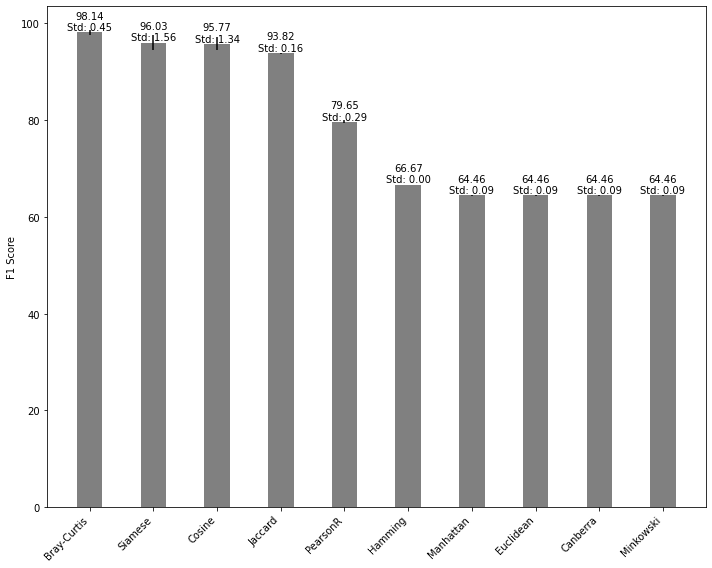

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data for the test scores
methods = ["Siamese", "Cosine", "Manhattan", "Bray-Curtis", "Euclidean", "PearsonR", "Jaccard", "Hamming", "Canberra", "Minkowski"]
test_means = [np.mean(cvTestscoresSiameseAll), np.mean(cvTestscoresCosineAll), np.mean(cvTestscoresManhattanAll),
              np.mean(cvTestscoresBrayCurtisAll), np.mean(cvTestscoresEuclideanAll),
              np.mean(cvTestscoresPearsonRAll), np.mean(cvTestscoresJaccardAll), np.mean(cvTestscoresHammingAll),
              np.mean(cvTestscoresCanberraAll), np.mean(cvTestscoresMinkowskiAll)]
test_stds = [np.std(cvTestscoresSiameseAll), np.std(cvTestscoresCosineAll), np.std(cvTestscoresManhattanAll),
             np.std(cvTestscoresBrayCurtisAll), np.std(cvTestscoresEuclideanAll),
             np.std(cvTestscoresPearsonRAll), np.std(cvTestscoresJaccardAll), np.std(cvTestscoresHammingAll),
             np.std(cvTestscoresCanberraAll), np.std(cvTestscoresMinkowskiAll)]

# Sort methods and corresponding test_means and test_stds in descending order of test means
sorted_methods, sorted_test_means, sorted_test_stds = zip(*sorted(zip(methods, test_means, test_stds), key=lambda x: x[1], reverse=True))

# Define the figure size
fig, ax = plt.subplots(figsize=(10, 8))

# Number of bars (one for each method)
num_methods = len(methods)
bar_width = 0.4
index = np.arange(num_methods)

# Create bars for test means
bar1 = ax.bar(index, sorted_test_means, bar_width, label='Test Mean', yerr=sorted_test_stds, color='grey')

# Set the x-axis labels to be the sorted method names
ax.set_xticks(index)
ax.set_xticklabels(sorted_methods, rotation=45, ha='right')


ax.set_ylabel('F1 Score')


# Annotate the bars with their values and standard deviations, placing the standard deviation text above the bars
for i, (v, std) in enumerate(zip(sorted_test_means, sorted_test_stds)):
    ax.text(i, v + 0.01, f"{v:.2f}\nStd: {std:.2f}", ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


In [17]:
#Overall Cosine Similarity Results for 100 Run
result_df = pd.DataFrame(cvTestscoresCosineAll)
result_df.describe()

,0
count,100.000000
mean,95.667028
std,1.362640
min,91.767363
25%,94.624506
50%,95.573123
75%,96.521739
max,98.260870


In [18]:
#Overall Cosine Similarity Results for 100 Run
result_df = pd.DataFrame(cvTestscoresManhattanAll)
result_df.describe()

,0
count,100.000000
mean,64.473037
std,0.065477
min,64.288780
25%,64.405544
50%,64.512615
75%,64.514367
max,64.516129


In [19]:
#Overall Cosine Similarity Results for 100 Run
result_df = pd.DataFrame(cvTestscoresBrayCurtisAll)
result_df.describe()

,0
count,100.000000
mean,98.180362
std,0.436008
min,96.668448
25%,97.907525
50%,98.249623
75%,98.400564
max,99.177142


In [20]:
#Overall Cosine Similarity Results for 100 Run
result_df = pd.DataFrame(cvTestscoresEuclideanAll)
result_df.describe()

,0
count,100.000000
mean,64.458369
std,0.082001
min,64.182602
25%,64.403793
50%,64.511723
75%,64.514367
max,64.515248


In [21]:
#Overall Cosine Similarity Results for 100 Run
result_df = pd.DataFrame(cvTestscoresChebysevAll)
result_df.describe()

,0
count,100.000000
mean,64.458369
std,0.082001
min,64.182602
25%,64.403793
50%,64.511723
75%,64.514367
max,64.515248


In [22]:
#Overall Cosine Similarity Results for 100 Run
result_df = pd.DataFrame(cvTestscoresPearsonRAll)
result_df.describe()

,0
count,100.000000
mean,79.664610
std,0.324723
min,79.101582
25%,79.412749
50%,79.632194
75%,79.888287
max,80.606302


In [23]:
#Overall Cosine Similarity Results for 100 Run
result_df = pd.DataFrame(cvTestscoresJaccardAll)
result_df.describe()

,0
count,100.000000
mean,93.794890
std,0.193343
min,93.317024
25%,93.686798
50%,93.805194
75%,93.931072
max,94.164983


In [24]:
#Overall Cosine Similarity Results for 100 Run
result_df = pd.DataFrame(cvTestscoresHammingAll)
result_df.describe()

,0
count,100.000000
mean,66.666667
std,0.000000
min,66.666667
25%,66.666667
50%,66.666667
75%,66.666667
max,66.666667


In [21]:
#Overall Cosine Similarity Results for 100 Run
result_df = pd.DataFrame(cvTestscoresCanberraAll)
result_df.describe()

,0
count,100.000000
mean,64.476078
std,0.080507
min,64.069287
25%,64.509987
50%,64.513475
75%,64.514367
max,64.516129


In [26]:
#Overall Siamese Network Results for 100 Run
result_df = pd.DataFrame(cvTestscoresSiameseAll)
result_df.describe()

,0
count,100.000000
mean,96.336417
std,1.440933
min,91.866667
25%,95.704348
50%,96.591304
75%,97.460870
max,99.200000


In [27]:
#Overall Minkowski Results for 100 Run
result_df = pd.DataFrame(cvTestscoresMinkowskiAll)
result_df.describe()

,0
count,100.000000
mean,64.458369
std,0.082001
min,64.182602
25%,64.403793
50%,64.511723
75%,64.514367
max,64.515248


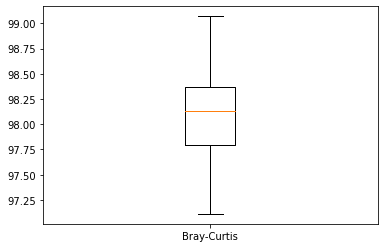

In [20]:
data = [cvTestscoresBrayCurtisAll]
names = ['Bray-Curtis']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(data)
ax.set_xticklabels(names)
plt.show()

In [ ]:
data = [cvTestscoresPearsonRAll]

names = ['Pearson']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(data)
ax.set_xticklabels(names)
plt.show()

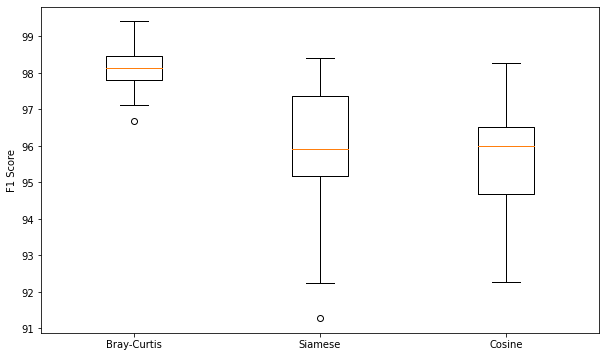

In [18]:
import matplotlib.pyplot as plt

data = [cvTestscoresBrayCurtisAll, cvTestscoresSiameseAll, cvTestscoresCosineAll]
names = ['Bray-Curtis', 'Siamese', 'Cosine']

fig, ax = plt.subplots(figsize=(10, 6))

ax.boxplot(data, labels=names)
ax.set_ylabel('F1 Score')

plt.show()


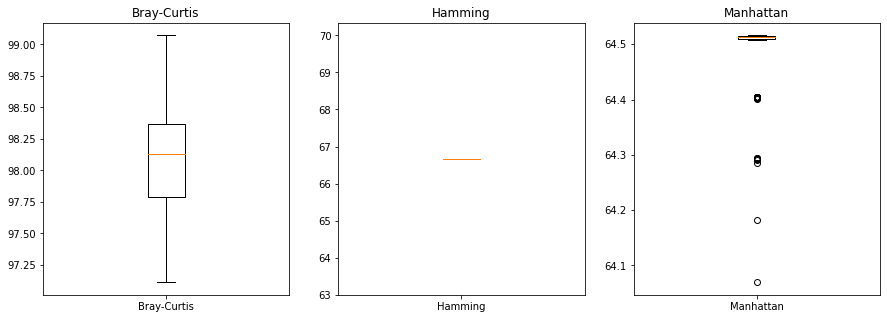

In [23]:
data = [cvTestscoresBrayCurtisAll, cvTestscoresHammingAll, cvTestscoresManhattanAll]
names = ['Bray-Curtis', 'Hamming', 'Manhattan']

# Yan yana 3 grafiği oluştur
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    ax = axes[i]
    ax.boxplot(data[i])
    ax.set_title(names[i])
    ax.set_xticklabels([names[i]])

plt.show()

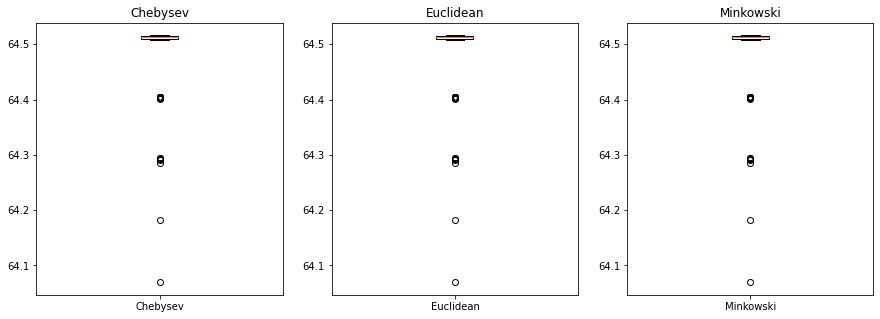

In [24]:
data = [cvTestscoresChebysevAll, cvTestscoresEuclideanAll, cvTestscoresMinkowskiAll]
names = ['Chebysev', 'Euclidean', 'Minkowski']

# Yan yana 3 grafiği oluştur
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    ax = axes[i]
    ax.boxplot(data[i])
    ax.set_title(names[i])
    ax.set_xticklabels([names[i]])

plt.show()

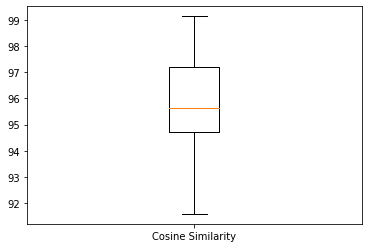

In [28]:
data = [cvTestscoresCosineAll]
names = ['Cosine Similarity']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(data)
ax.set_xticklabels(names)
plt.show()

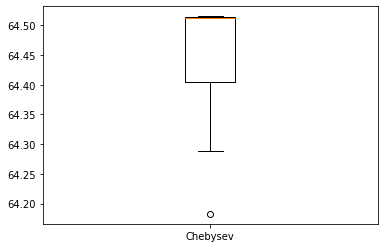

In [29]:
data = [cvTestscoresChebysevAll]
names = ['Chebysev']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(data)
ax.set_xticklabels(names)
plt.show()

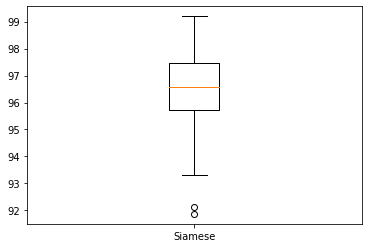

In [33]:
data = [cvTestscoresSiameseAll]
names = ['Siamese']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(data)
ax.set_xticklabels(names)
plt.show()

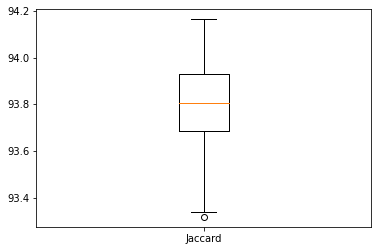

In [34]:
data = [cvTestscoresJaccardAll]
names = ['Jaccard']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(data)
ax.set_xticklabels(names)
plt.show()

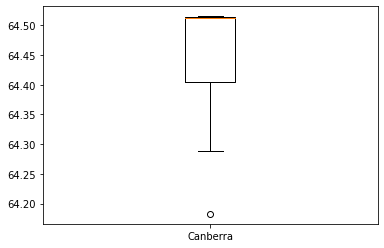

In [32]:
data = [cvTestscoresCanberraAll]
names = ['Canberra']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(data)
ax.set_xticklabels(names)
plt.show()

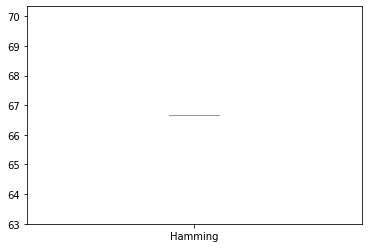

In [31]:
data = [cvTestscoresHammingAll]
names = ['Hamming']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(data)
ax.set_xticklabels(names)
plt.show()

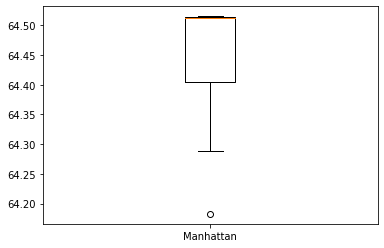

In [30]:
data = [cvTestscoresManhattanAll]
names = ['Manhattan']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(data)
ax.set_xticklabels(names)
plt.show()

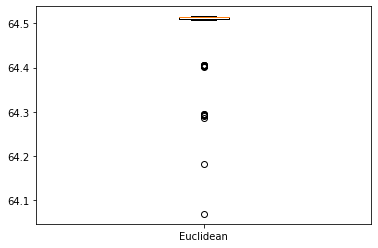

In [26]:
data = [cvTestscoresEuclideanAll]
names = ['Euclidean']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(data)
ax.set_xticklabels(names)
plt.show()

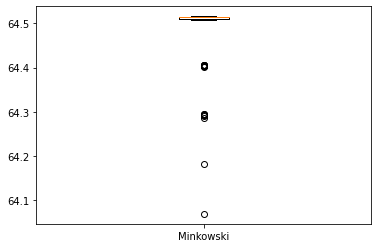

In [25]:
data = [cvTestscoresMinkowskiAll]
names = ['Minkowski']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(data)
ax.set_xticklabels(names)
plt.show()